# Read data from xml

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import xml.etree.ElementTree as ET
from itertools import chain

In [3]:
def get_dynamic_data(xml_file):
    def process_interval(interval):
        for e in interval.findall('edge'):
            for lane in e.findall('lane'):            
                yield {
                    'begin': float(interval.get('begin')),
                    'lane_id': lane.get('id'),
                    'density': float(lane.get('density', 0)),
                    'speed': float(lane.get('speed', 0)),
                    'occupancy': float(lane.get('occupancy', 0))
                }

    def convert_to_csv(xml_file):
        root = ET.parse(xml_file).getroot()
        intervals = root.findall('interval')
        data = pd.DataFrame(chain(*map(process_interval, intervals)), columns=['begin', 'lane_id', 'density', 'speed','occupancy'])
        data['density'] = data.density / 1000 # convert from veh/km to veh/m
        data['flow'] = data['density'] * data['speed'] # add flow column
        return data
    
    return convert_to_csv(xml_file)

def get_static_data(xml_file):
    def process_edge(edge):
        for lane in edge.findall('lane'):            
            yield {
                'lane_id': lane.get('id'),
                'max_speed': float(lane.get('speed', 0)),
            }
    def convert_to_csv(xml_file):
        root = ET.parse(xml_file).getroot()
        edges = root.findall('edge')
        data = pd.DataFrame(chain(*map(process_edge, edges)), columns=['lane_id', 'max_speed'])
        return data
    return convert_to_csv(xml_file)

In [4]:
# Get data for 3 different models
data_default_lanes = get_dynamic_data('maryland/fundamental_out.xml')
data_platoons_lanes = get_dynamic_data('maryland/fundamental_out_platoons_model.xml')
data_gm_lanes = get_dynamic_data('maryland/fundamental_out_GM_model.xml')

data_default_wo_tl_lanes = get_dynamic_data('maryland/fundamental_out_wo_TL_model.xml')
# data_platoons_wo_tl_lanes = get_dynamic_data('maryland/fundamental_out_wo_TL_platoons_model.xml')

In [5]:
lanes_data = get_static_data('maryland/moco.net.xml')

In [6]:
ALL_LANES = lanes_data.lane_id.values.tolist()

In [7]:
def get_lane_max_speed(lane_id):
    return float(lanes_data[lanes_data['lane_id'] == lane_id].max_speed)

# Plot fundamental diagram

In [8]:
def get_fundamental(way_id, data, max_rho=0.20, verbose=True):
    lane = data.loc[way_id]
    # exclude max density flows
#     lane = lane[lane['density'] != max_rho]
    # rho_1 and Q_1
    rho_1, q_1 = lane.loc[lane.flow.idxmax()][['density', 'flow']]

    rho_max = max(max_rho, lane.density.max())
    
    # Get values of free flow
    free_flow = lane[lane.density.between(rho_1 * 3 / 8, rho_1 * 5 / 8)]
    try:
        rho_0, q_0 = free_flow.loc[free_flow.flow.idxmax()][['density', 'flow']]
    except ValueError:
        if verbose:
            print('There are no points in the interval of `free flow`: rho in [%.3f : %.3f]' % (rho_1 * 3 / 8, rho_1 * 5 / 8))
        rho_0, q_0 = rho_1, q_1
        
    # Get rho_2 and Q_2
    max_flow = lane.flow.max()
    max_density = lane.density.max()
    if max_flow == 0 or max_density == 0:
        q_2, rho_2 = 0., 0.
    else:
        most_distant_point = lane.loc[((lane.flow / lane.flow.max()).pow(2) + (lane.density / lane.density.max()).pow(2)).pow(1./2).idxmax()]
        q_2, rho_2 = most_distant_point.flow, most_distant_point.density
    
    if verbose:
        print('Q0:{:.3f}\nQ1:{:.3f}\nQ2:{:.3f}\nrho0:{:.3f}\nrho1:{:.3f}\nrho2:{:.3f}\nrho*:{:.3f}'.format(q_0, q_1, q_2, rho_0, rho_1, rho_2, rho_max))
        print('free_flow | {:3.3f}:{:3.3f}(rho_1)\nsync_flow | {:3.3f}(rho_1):{:3.3f}(rho_2)\njam_flow  | {:3.3f}(rho_2):{:3.3f}(rho_*)'.format(0, rho_1, rho_1, rho_2, rho_2, rho_max))
    
    return rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2

In [86]:
def plot_fundamental(way_id, data):
    rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2 = get_fundamental(way_id, data)
    lane = data.loc[way_id]
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
    fig.suptitle('Way id: %s' % way_id)
    ax0.set_title('Fundamental diagram')
    ax0.set_xlabel('Density, veh/m')
    ax0.grid()
    ax0.set_ylabel('Flow, veh/s')
    ax0.scatter(lane.density, lane.flow)

    ax1.set_title('Optimal speed')
    ax1.set_xlabel('Density, veh/m')
    ax1.set_ylabel('V, m/s')
    ax1.grid()
    ax1.scatter(lane.density, lane.speed)
    
    for ax in [ax0, ax1]:
        ax.axvline(x=0, linestyle='-', c='r')
        ax.axvline(x=rho_1, linestyle='-', c='g')
        ax.axvline(x=rho_2, linestyle='--', c='b')
        ax.axvline(x=rho_max, linestyle='--', c='r')

    fig.tight_layout()
    return fig, ax0, ax1

In [10]:
def plot_hulls(way_id, data):
    rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2 = get_fundamental(way_id, data)
    lane = data.loc[way_id]
    points = lane[['density', 'speed']].values
    points[:2] > 0.01

## Average over the road 

In [11]:
# Get the data indexed by road and lane ids and time of detection
def average_over_lanes(data):
    t_data = data.copy()
    t_data[['road_id', 'lane_id']] = t_data.lane_id.str.rsplit('_', n=1, expand=True)
    return t_data.groupby(['road_id', 'begin']).mean(), data.groupby(['lane_id', 'begin']).mean()

In [12]:
data_default_roads, data_default_lanes = average_over_lanes(data_default_lanes)
data_platoons_roads, data_platoons_lanes = average_over_lanes(data_platoons_lanes)
data_gm_roads, data_gm_lanes = average_over_lanes(data_gm_lanes)

# Without traffic lights
data_default_wo_tl_roads, data_default_wo_tl_lanes = average_over_lanes(data_default_wo_tl_lanes)
# data_platoons_roads, data_platoons_lanes = average_over_lanes(data_platoons_lanes)

In [13]:
ALL_ROADS = data_default_roads.index.levels[0].tolist()

In [14]:
# Example
data_default_lanes.tail(5)

density  speed  occupancy     flow
lane_id  begin                                     
gneE17_1 3300.0   0.0000    0.0       0.00  0.00000
         3360.0   0.0000    0.0       0.00  0.00000
         3420.0   0.0000    0.0       0.00  0.00000
         3480.0   0.0000    0.0       0.00  0.00000
         3540.0   0.0013   13.3       0.63  0.01729

In [15]:
# Example
data_default_roads.tail(5)

density  speed  occupancy      flow
road_id    begin                                       
gneE17.147 3300.0  0.075278  0.526     37.630  0.031594
           3360.0  0.072950  1.388     36.340  0.054188
           3420.0  0.058358  1.672     29.024  0.068593
           3480.0  0.086362  0.174     43.128  0.015203
           3540.0  0.059858  1.222     29.784  0.069409

In [17]:
data_default_roads.describe()

,density,speed,occupancy,flow
count,59460.000000,59460.000000,59460.000000,59460.000000
mean,0.009234,2.396315,3.586234,0.033299
std,0.028384,5.483004,11.446331,0.149783
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000960,0.045000,0.333750,0.002169
max,0.200000,29.540000,88.055000,5.118000


In [18]:
# Let's find the most loaded roads
data_default_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(5)

,density,speed,occupancy,flow
road_id,,,,
:1688843682_0,0.159019,12.123083,5.363667,2.019588
:290051915_0,0.186150,11.221167,37.900417,1.954724
:298136038_0,0.050444,20.954500,1.430583,1.280616
:648538912_0,0.135266,11.272750,18.817167,0.987041
:648538786_0,0.022691,11.792556,0.641889,0.559450


# Get characteristic values

### Utility

In [19]:
def free_flow_segment(q_0, q_1, rho_1):
    alpha_1 = (4 * q_0 - q_1) / rho_1
    alpha_2 = 2 * (q_1 - 2*q_0) / rho_1 / rho_1
    print(rho_1 / 0.0025)
    rho = np.linspace(0, rho_1, rho_1 / 0.0025)
    q = np.square(rho) * alpha_2 + rho * alpha_1
    return rho, q

def jam_flow_segment(q_2, rho_2, rho_max):
    c_star = q_2 / (rho_max - rho_2)
    rho = np.linspace(rho_2, rho_max, (rho_max - rho_2) / 0.0025)
    q = c_star * (rho_max - rho)
    return rho, q

In [20]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def plot_convex_hull_(points):
    hull = ConvexHull(points)
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

def plot_convex_hull(way_id, data, y='flow'):    
    lane = data.loc[way_id]
    points = lane[['density', y]].values
    plot_convex_hull_(points)

### Fundamental diagrams examples

Q0:0.503
Q1:0.706
Q2:0.656
rho0:0.028
rho1:0.045
rho2:0.067
rho*:0.200
free_flow | 0.000:0.045(rho_1)
sync_flow | 0.045(rho_1):0.067(rho_2)
jam_flow  | 0.067(rho_2):0.200(rho_*)


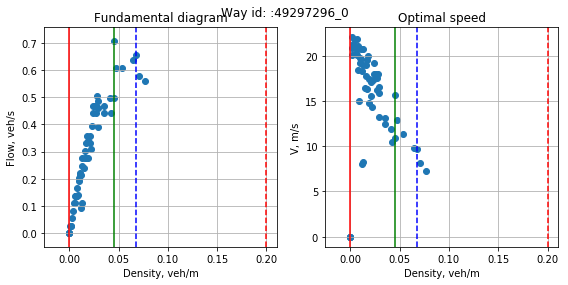

In [85]:
plot_fundamental(':49297296_0', data_default_roads)

### Interpolate function

In [24]:
from scipy.interpolate import UnivariateSpline

In [25]:
def adjust_nonunique_x(a, eps=1e-5):
    uniq, inv, counts = np.unique(a[:, 0], return_counts=True, return_inverse=True)
    for u, c in zip(uniq, counts):
        if c > 1:
            mask = a[:, 0] == u
            non_unique_vals = a[mask]
            non_unique_idx = np.nonzero(mask)[0]
            i = non_unique_idx[non_unique_vals[:, 1].argsort()]
            a = np.delete(a, i[:-1], axis=0)
    return a

In [71]:
import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch

def interpolate_fundamental(way_id, data, y_axis='speed', vis=True, verbose=True, desc='road', vis_ch=):    
    # Calculate fundamental critical points
    rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2 = get_fundamental(way_id, data, verbose=verbose)

    # Get lane points
    lane = data.loc[way_id]
    points = np.unique(lane[['density', y_axis]].values, axis=0)
    
    # Plot segments
    if vis:
        fig, ax = plt.subplots()
        ax.axvline(x=0, linestyle='-', c='r')
        ax.axvline(x=rho_1, linestyle='-', c='g')
        ax.axvline(x=rho_2, linestyle='--', c='b')
        ax.axvline(x=rho_max, linestyle='--', c='r')
        ax.scatter(points[:, 0], points[:, 1], color='b', s=7)
        ax.set_xlim(0, 0.21)
        ax.set_title('%s: `%s`' % (desc, way_id))
    
    # Interpolate by splines
    segments = [(0, rho_1), (rho_1, rho_2), (rho_2, rho_max)]
    all_selected_points = []
    for ind, seg in enumerate(segments):
        seg_points = points[np.where(np.logical_and(points[:, 0] >= seg[0], points[:, 0] <= seg[1]))]
#         print('Segment', seg)
        selected_pts, hull = interpolate_points(seg_points)

        # Add terminal points
        if ind == 2 and not (selected_pts[:, 0] == 0.2).any():
            selected_pts = np.append(selected_pts, [0.2, 0.]).reshape(-1, 2) 
            
#         print('Seg points', np.unique(selected_pts, axis=0))

        # Add last point if necessary
        if len(selected_pts > 0):
            all_selected_points.append(selected_pts)
            if vis:
                if hull is not None:
                    ax.add_patch(PolygonPatch(hull, fill=False, color='green'))
                ax.scatter(selected_pts[:, 0], selected_pts[:, 1], color='red', s=10)
    all_selected_points = np.vstack(all_selected_points)
    all_selected_points = make_increasing_x((all_selected_points[:, 0], all_selected_points[:, 1]))
    spl = UnivariateSpline(all_selected_points[:, 0], all_selected_points[:, 1], k=1, s=0, ext=3)
    # Plot spline
    if vis:
        smooth_x = np.linspace(0, 0.2, 100)
        ax.plot(smooth_x, spl(smooth_x), lw=2, c='m')
    plt.show()
    return spl
        
def make_increasing_x(points):
    # Filter all points which go left (if x(n) < x(n-1))
    x_prev = -1
    y_prev = 1000
    selected_pts = []
    for x, y in zip(*points):
        if x > x_prev:
            x_prev = x
            if y <= y_prev:
                y_prev = y
            else:
                selected_pts.pop(-1)
            selected_pts.append((x, y))
            
    return np.array(selected_pts)
    

def interpolate_points(points):
    # find alpha hull
#     alpha = 0.95 * alphashape.optimizealpha(points)
    if len(np.unique(points, axis=0)) > 2:
        # Build alpha-hull
        if len(np.unique(points[:, 0])) < 2:
            hull_pts = points[:, 0], points[:, 1]
            hull = None
        else:
            alpha = 0.0015
            try:
                hull = alphashape.alphashape(points, alpha=alpha)
                hull_pts = hull.exterior.coords.xy
            except AttributeError:
                print('Cannot find conacave hull, finding the convex hull')
                alpha = 0.
                hull = alphashape.alphashape(points, alpha=alpha)
                hull_pts = hull.exterior.coords.xy
                
        # Get only top points
        x, y = np.array(hull_pts[0]), np.array(hull_pts[1])
        y_max_ind = np.argmax(y)
        potenital_x_max = x == np.max(x)
        most_right = int(np.max(np.nonzero(y == np.max(y[potenital_x_max]))[0]))
        if y_max_ind <= most_right:
            top_points = x[y_max_ind:most_right + 1], y[y_max_ind:most_right + 1]
        else:
            top_points = np.append(x[y_max_ind:-1],  x[:most_right + 1]), np.append(y[y_max_ind:-1], y[:most_right + 1])
    else:
        top_points = points[:, 0], points[:, 1]
        hull = None
    selected_pts = make_increasing_x(top_points)
    return selected_pts, hull

Q0:0.850
Q1:5.118
Q2:5.118
rho0:0.077
rho1:0.200
rho2:0.200
rho*:0.200
free_flow | 0.000:0.200(rho_1)
sync_flow | 0.200(rho_1):0.200(rho_2)
jam_flow  | 0.200(rho_2):0.200(rho_*)


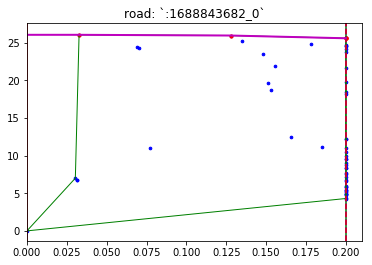

In [73]:
interpolate_fundamental(':1688843682_0', data_default_roads, y_axis='speed')

# Different roads

In [51]:
from tqdm.autonotebook import tqdm
def plot_samples(sample_ids, data):
    for sample in tqdm(sample_ids):
        interpolate_fundamental(sample, data, y_axis='speed', vis=True, verbose=False)

## Comparison

Compare the same roads for different roads. Let's take union of top 5 roads by `flow` for each model and compare them

In [52]:
top_roads_default = data_default_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(10)
top_roads_platoons = data_platoons_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(10)
top_roads_gm = data_gm_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(10)

top_wo_tl = ['5982169#1', '116069186#1', '50846720#8', '50846720#1', '50846755#3.145', '50846755#2.0']

In [80]:
def compare(idx, data, desc):
    if not isinstance(data, list):
        data = [data]
    if not isinstance(desc, list):
        desc = [desc]
    for dat, des in zip(data, desc):
        interpolate_fundamental(idx, dat, y_axis='speed', vis=True, verbose=False, desc=des, vis_ch=True)

In [81]:
idx_for_comparsion = top_roads_default.index.union(top_roads_platoons.index).union(top_roads_gm.index).union(top_wo_tl)

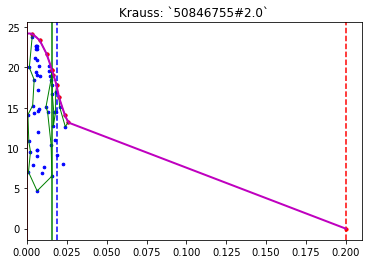

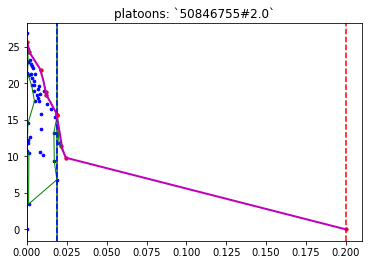

Cannot find conacave hull, finding the convex hull


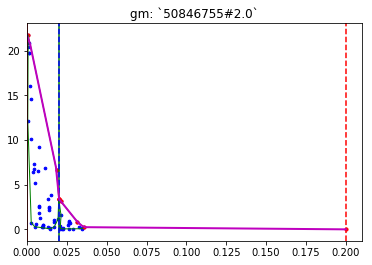

In [82]:
# TODO: добавить другие модели
compare('50846755#2.0', [data_default_roads, data_platoons_roads, data_gm_roads], ['Krauss', 'platoons', 'gm'])

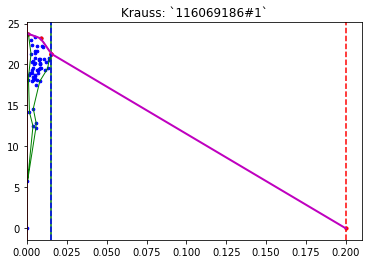

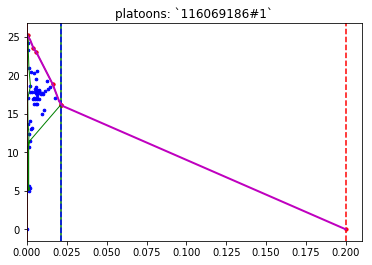

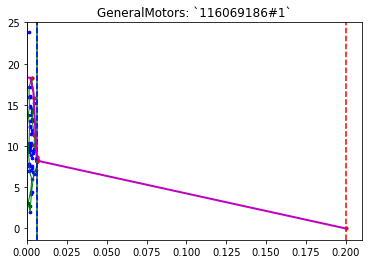

Cannot find conacave hull, finding the convex hull


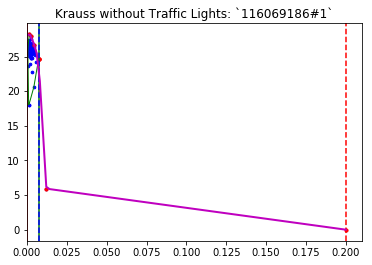

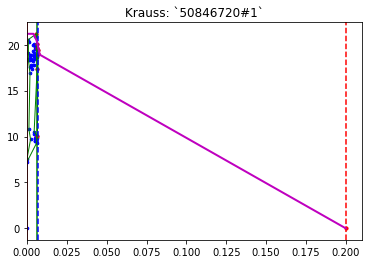

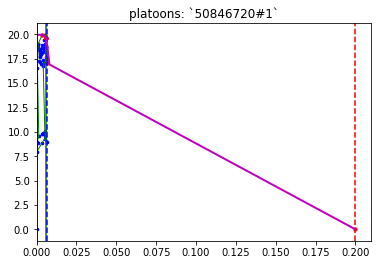

Cannot find conacave hull, finding the convex hull


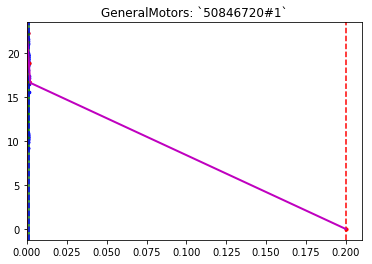

Cannot find conacave hull, finding the convex hull


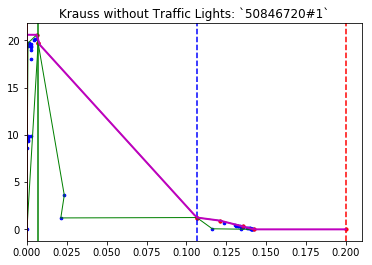

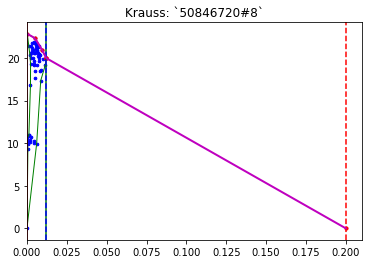

Cannot find conacave hull, finding the convex hull


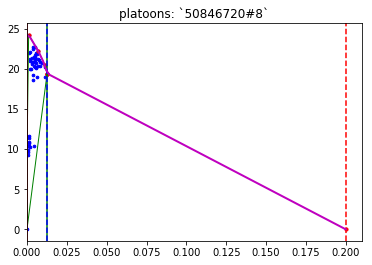

Cannot find conacave hull, finding the convex hull


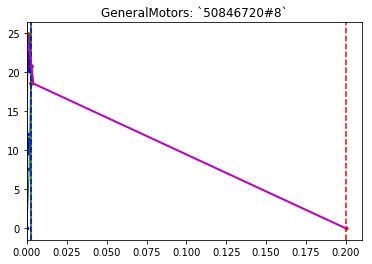

Cannot find conacave hull, finding the convex hull


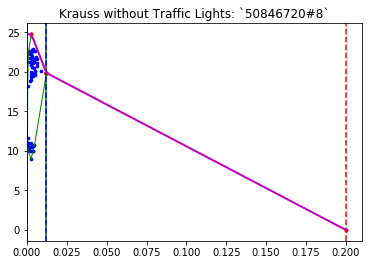

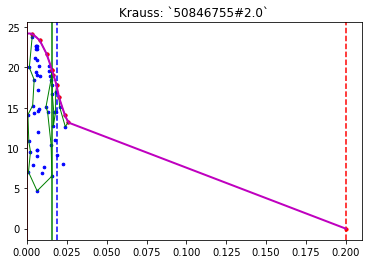

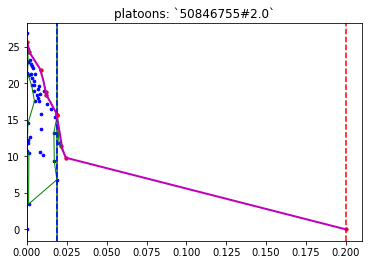

Cannot find conacave hull, finding the convex hull


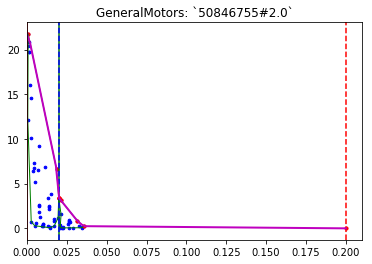

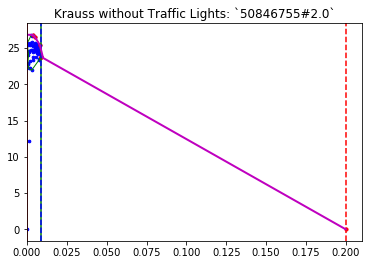

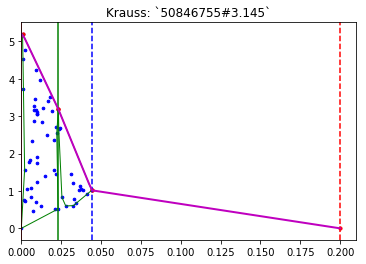

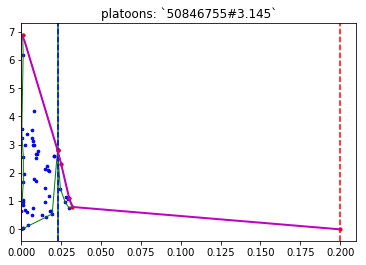

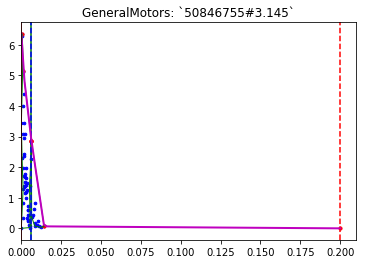

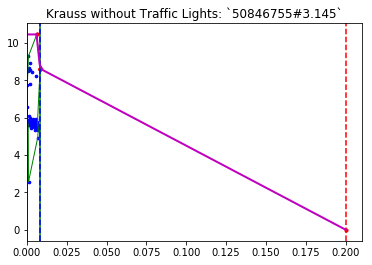

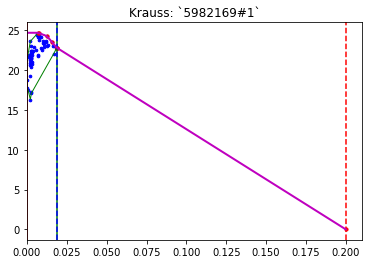

Cannot find conacave hull, finding the convex hull


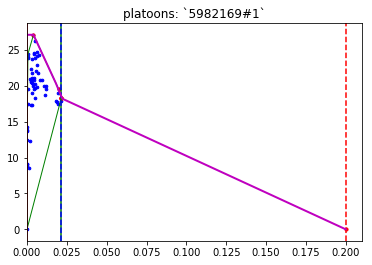

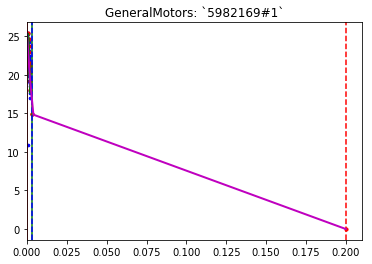

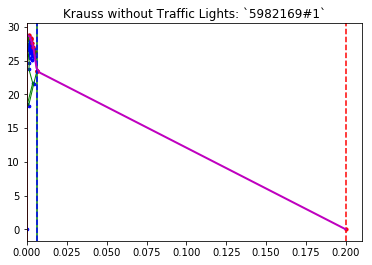

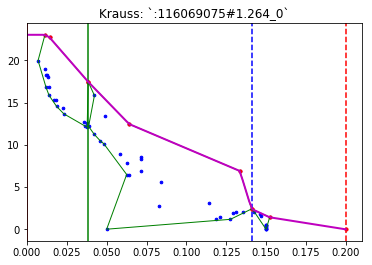

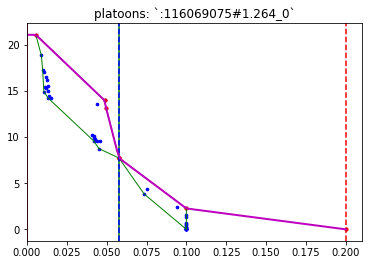

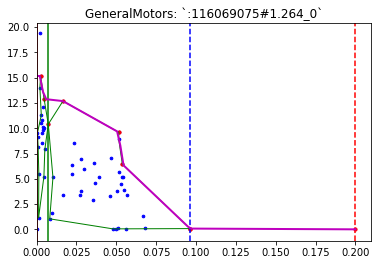

Cannot find conacave hull, finding the convex hull


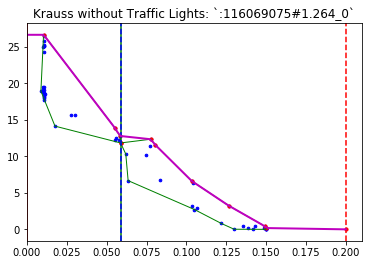

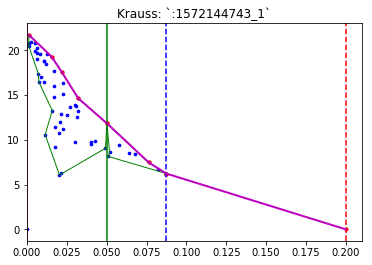

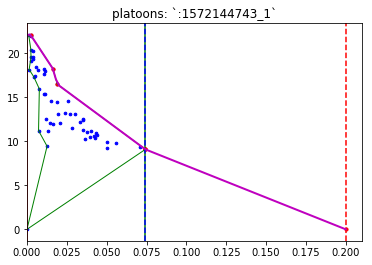

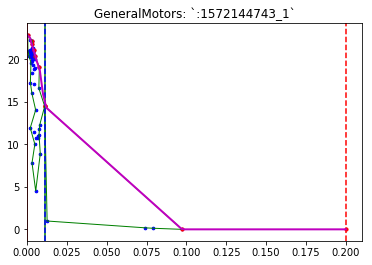

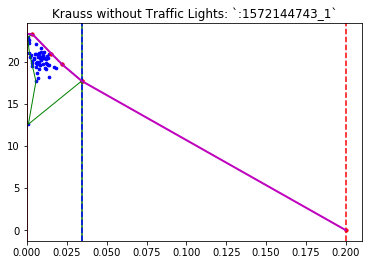

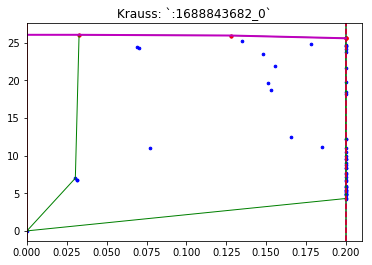

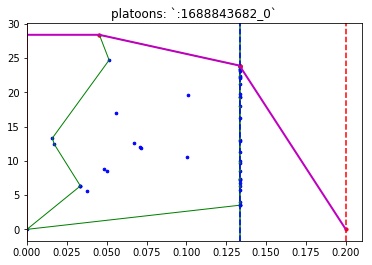

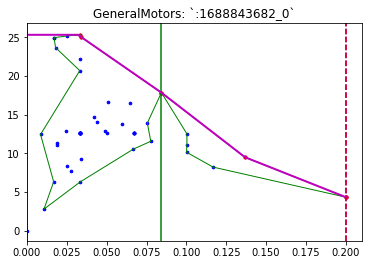

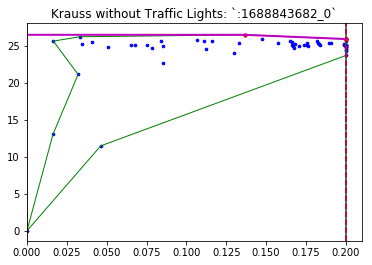

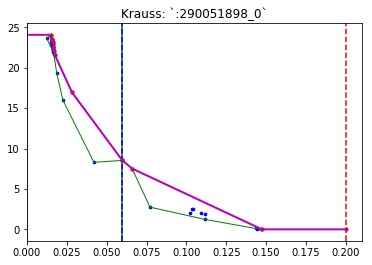

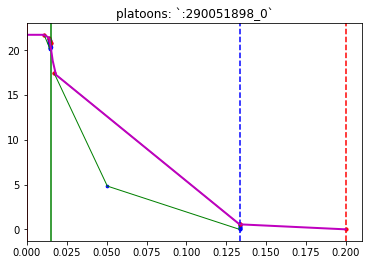

Cannot find conacave hull, finding the convex hull
Cannot find conacave hull, finding the convex hull


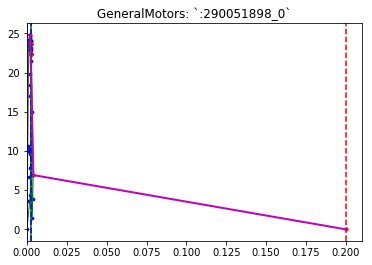

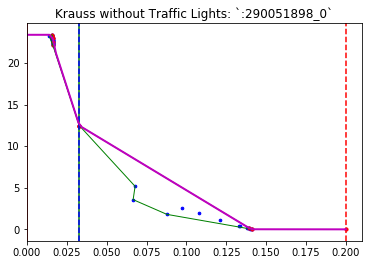

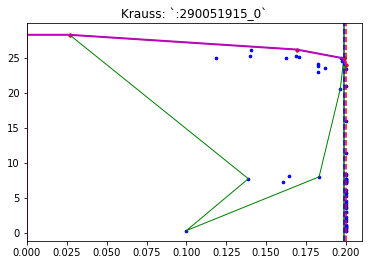

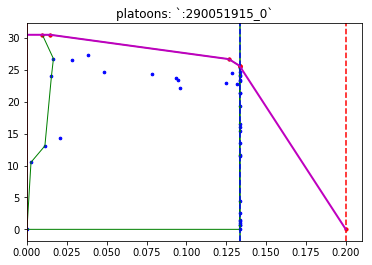

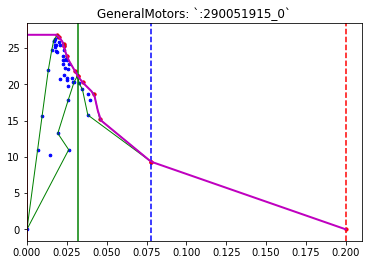

Cannot find conacave hull, finding the convex hull


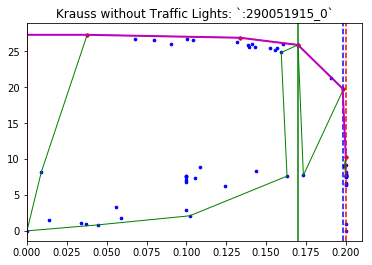

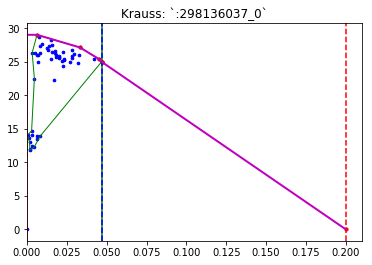

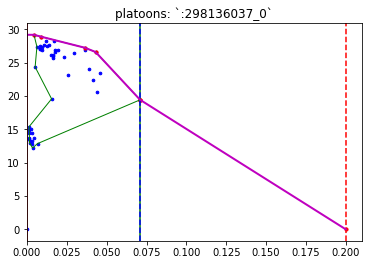

Cannot find conacave hull, finding the convex hull


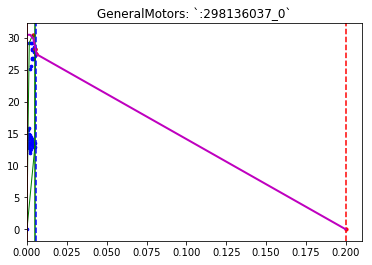

Cannot find conacave hull, finding the convex hull


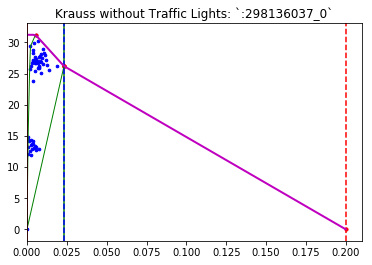

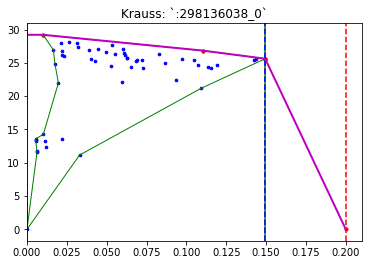

Cannot find conacave hull, finding the convex hull


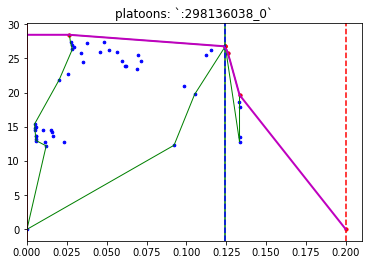

Cannot find conacave hull, finding the convex hull


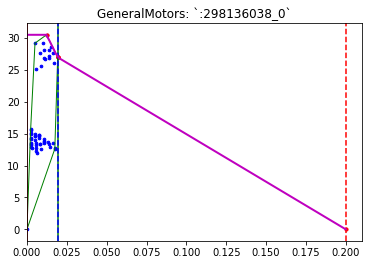

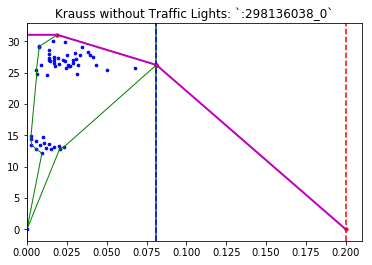

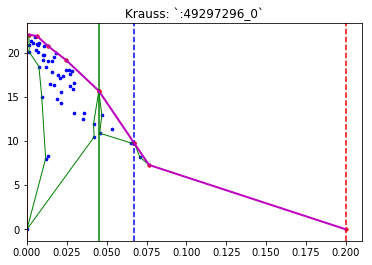

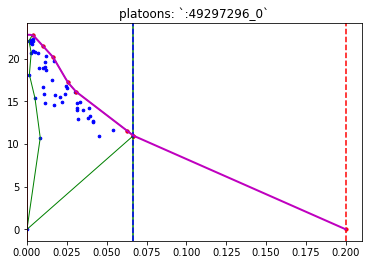

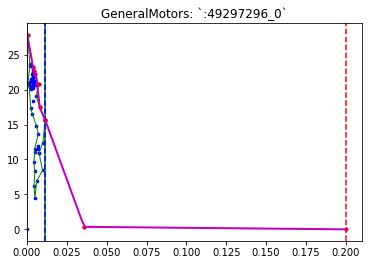

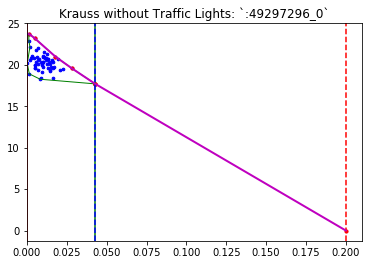

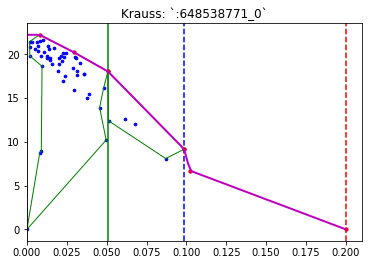

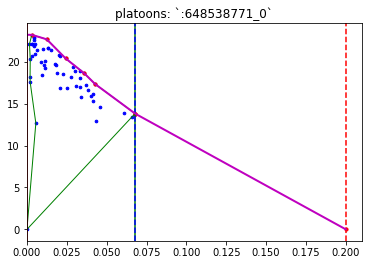

Cannot find conacave hull, finding the convex hull


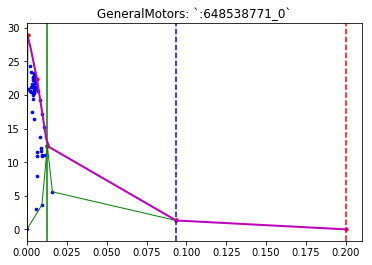

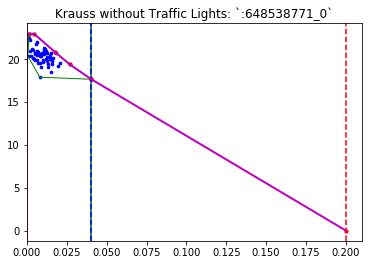

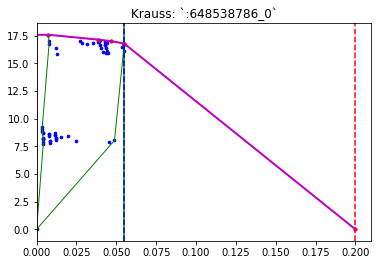

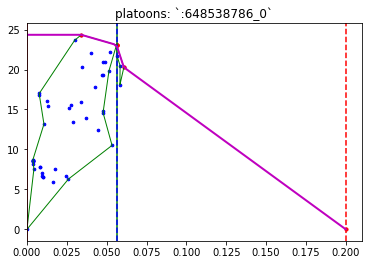

Cannot find conacave hull, finding the convex hull


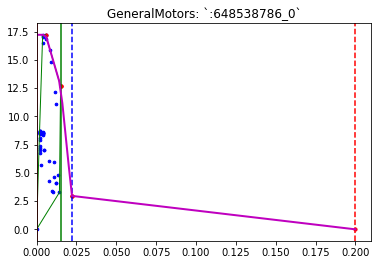

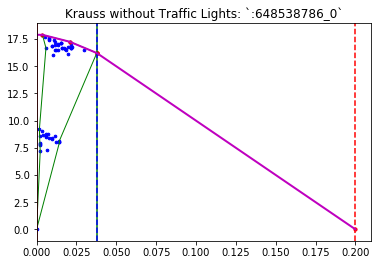

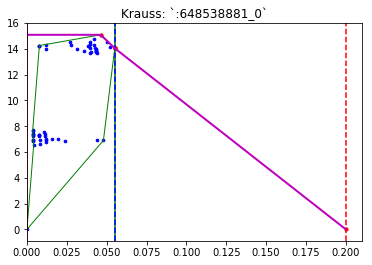

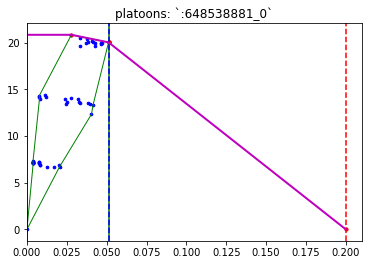

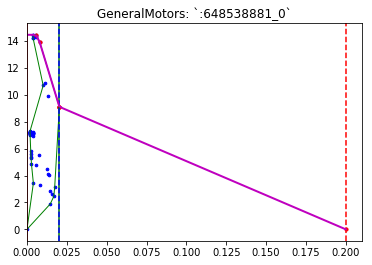

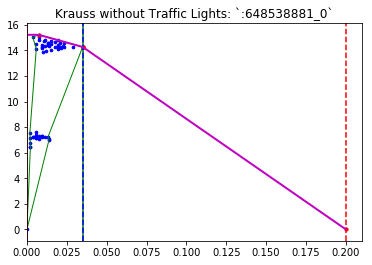

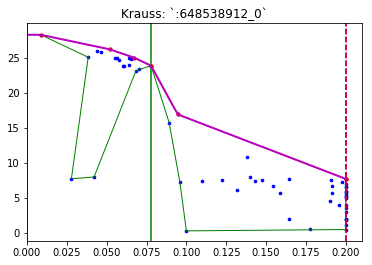

Cannot find conacave hull, finding the convex hull


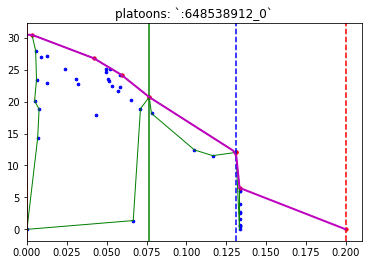

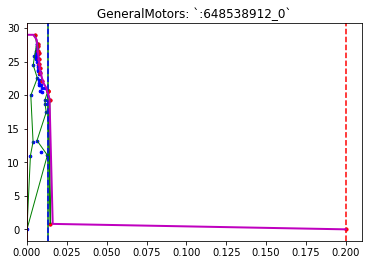

Cannot find conacave hull, finding the convex hull


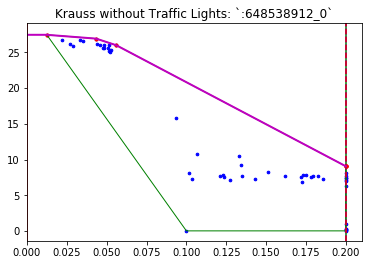

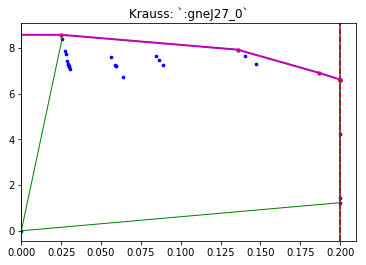

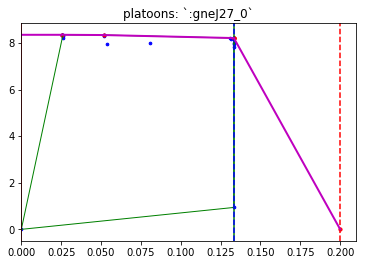

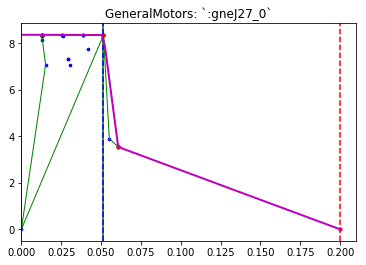

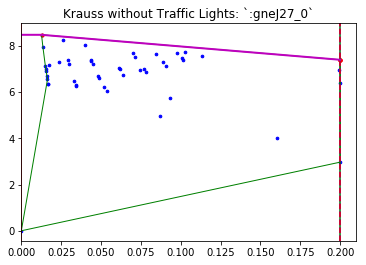

In [79]:
for idx in idx_for_comparsion:
    compare(idx, [data_default_roads, data_platoons_roads, data_gm_roads, data_default_wo_tl_roads], 
            ['Krauss', 'platoons', 'GeneralMotors', 'Krauss without Traffic Lights'])
    print('======' * 7)
    print('======' * 7)

# Integral characteristics

In [279]:
def plot_integral_throughput(data, model_name=''):
    d = data.groupby('begin').mean()
    time_table = data.index.get_level_values(1)
    dt = time_table[1] - time_table[0]
    x, y = d.index, d.flow.values
    mask = x < 3601
    x, y = x[mask], y[mask]
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(x, y)
    ax[0].set_title('Differential flow')
    ax[0].set_xlabel('t, sec')
    ax[0].set_ylabel('Average flow per road, veh/sec')
    int_y = np.cumsum(y) * dt # number of seconds in time interval
    ax[1].plot(x, int_y)
    ax[1].set_title('Integral flow')
    ax[1].set_ylabel('# vehicles per road')
    ax[1].set_xlabel('t, sec')
    fig.suptitle('Roads for %s' % model_name)
    plt.show()
    print('Total vehicles throughput = %d(veh/h)' % (np.round(int_y[-1]) * len(data.index.get_level_values(0).unique())))

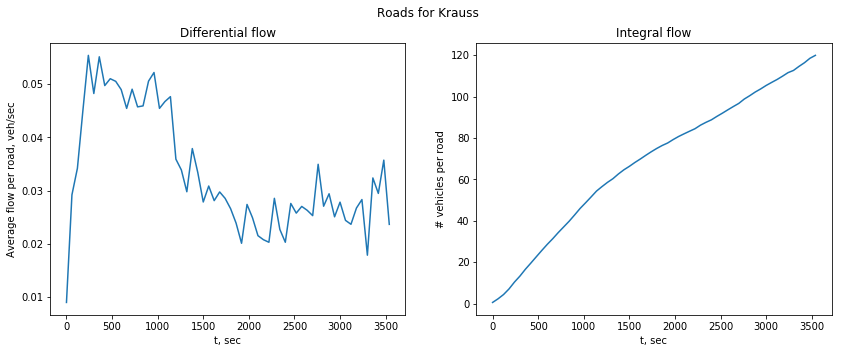

Total vehicles throughput = 118920(veh/h)


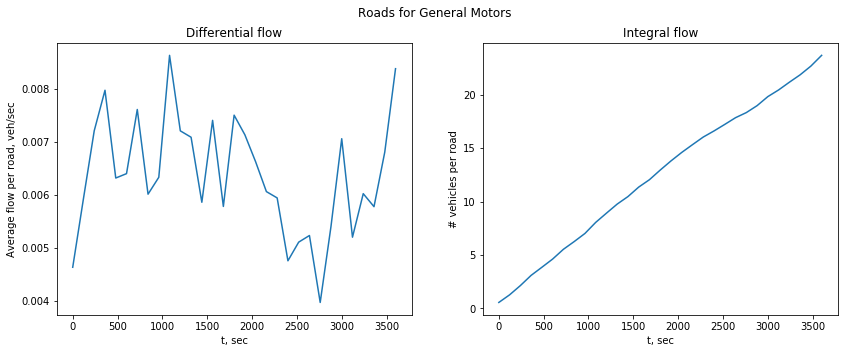

Total vehicles throughput = 23784(veh/h)


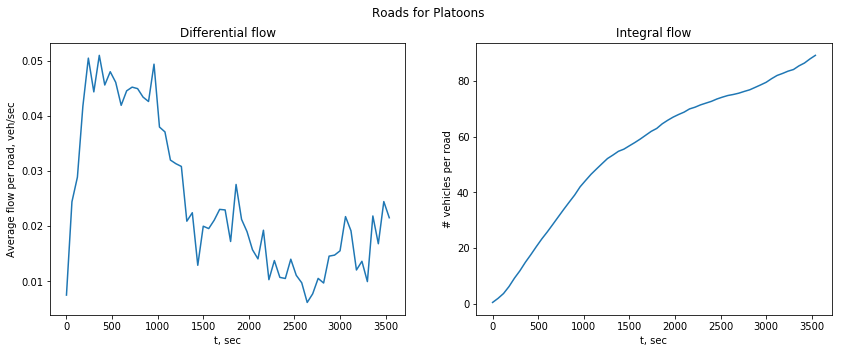

Total vehicles throughput = 88199(veh/h)


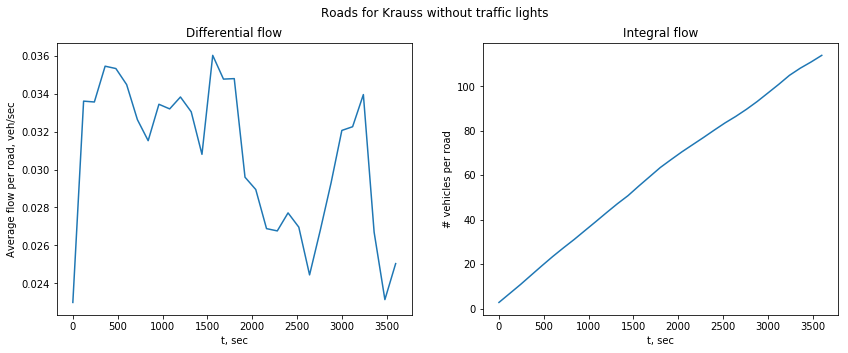

Total vehicles throughput = 116166(veh/h)


In [281]:
# data_default_roads.loc[idx_for_comparsion]
for d, name in zip([data_default_roads, data_gm_roads, data_platoons_roads, data_default_wo_tl_roads], 
                   ['Krauss', 'General Motors', 'Platoons', 'Krauss without traffic lights']):
    plot_integral_throughput(d, model_name=name)

# Build lane functions

Lane functions to get $dv/d\rho$ for each lane. The functions are estimated by default following model model of SUMO (modified Krauss) and then used in General Motors model to estimate $\alpha$

In [ ]:
from tqdm.autonotebook import tqdm
lane_dvdr = {}
for lane_id in tqdm(ALL_LANES):
    try:
        spl = interpolate_fundamental(lane_id, data_default_lanes, y_axis='speed', vis=False, verbose=False)
        lane_dvdr[lane_id] = spl.derivative(1)
    except:
        print('Something wrong with lane %s' % lane_id)

In [ ]:
# Check
spl = interpolate_fundamental('gneE17.147_3', data_default_lanes, y_axis='speed', vis=True)
der = spl.derivative(1)
for i in np.linspace(0, 0.2, 20):
    print(-i * der(i))

# Save and load

In [ ]:
import pickle

In [ ]:
with open('dvdr_gm.pickle', 'w') as f:
    pickle.dump(lane_dvdr, f)

In [ ]:
with open('dvdr_gm.pickle', 'r') as f:
    s = pickle.load(f)

In [ ]:
data_default_roads.groupby('road_id').mean().sort_values('density', ascending=False).head(10)

In [ ]:
-0.13 * s[':1688843682_0_0'](0.13)